In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
def process_df(df, weapon):    
    """Create a new dataframe that only contains necessary data
    
    Args:
        df (dataframe): contains data from a single weapon
        weapon (string): specifies which weapon data is contained
        
    Returns:
        a dataframe containing columns for the time, cumulative 
        experience gained, experience type and weapon used.
    """
    
    d1 = { 'Time (min)': df['Time (min)'],
           'Exp Gained': df['Def Exp Gained'] }
    defence_df = pd.DataFrame(data = d1)
    defence_df['Exp Type'] = "defence"

    d2 = { 'Time (min)': df['Time (min)'],
           'Exp Gained': df['HP Exp Gained'] }
    hitpoint_df = pd.DataFrame(data = d2)
    hitpoint_df['Exp Type'] = "hitpoint"

    processed_df = defence_df.append(hitpoint_df)
    processed_df['Weapon'] = weapon

    return processed_df

def get_combined_df(df1, df2):
    df1_copy, df2_copy = df1.copy(), df2.copy()    
    combined_df = df1_copy.append(df2_copy)
    
    return combined_df 

def get_regression_inputs(df, weapon):
    """Get the linear regression inputs for the given weapon
    
    Args:
        df: dataframe containing data from both weapons
        weapon: string specifying which weapon data to return  
        
    Returns:
        arrays containing the (cumulative) defence and hitpoint
        experience gained for the weapon
    """
    
    weapon_df = df[df['Weapon'] == weapon]
    defence_input = weapon_df.loc[weapon_df['Exp Type'] == "defence", 
                                  'Exp Gained'].values
    hitpoint_input = weapon_df.loc[weapon_df['Exp Type'] == "hitpoint", 
                                   'Exp Gained'].values

    return defence_input, hitpoint_input

def linear_regression(x, y):  
    """Perform linear regression using ordinary least squares
    
    Args:
        x (array): contains the time
        y (array): contains the cumulative experience obtained 
        
    Returns:
        an array containing the y-intercept and the slope of the
        best-fit line
    """
    
    X = np.ones((len(x), 2), np.uint64)
    X[:, 1] = x
    Xt = X.transpose()
    
    coefficients = ((np.linalg.inv(Xt.dot(X))).dot(Xt)).dot(y)
    coefficients[0], coefficients[1] = coefficients[1], coefficients[0]
    
    return coefficients

def get_regression_results(time, defence_exp, hitpoint_exp):
    """Get the results for defence and hitpoint exp from linear_regression 
    and linregress (Scipy's stats module)
    
    Args:
        time (array): contains the time intervals
        defence_exp (array): contains the cumulative defence experience
        hitpoint_exp (array): contains the cumulative hitpoint experience
        
    Returns:
        defence_coefficients (array): 
            linear regression coefficients for defence experience
        defence_linregress_results (floats): 
            linregress results for defence experience
        hitpoint_coefficients (array): 
            linear regression coefficients for hitpoint experience
        hitpoint_linregress_results (floats):
            linregress results for hiitpoint experience
    """
    
    defence_coefficients = linear_regression(time, defence_exp)
    defence_linregress_results = stats.linregress(time, defence_exp)
    hitpoint_coefficients = linear_regression(time, hitpoint_exp)
    hitpoint_linregress_results = stats.linregress(time, hitpoint_exp)

    return defence_coefficients, defence_linregress_results, \
           hitpoint_coefficients, hitpoint_linregress_results

def display_regression_results(coefficients, weapon): 
    matrix_message = "Slope and x-intercept using matricies:"
    scipy_message = "Slope and x-intercept using SciPy stats:"
    
    print("Linear regression results for the", weapon)
    print("Defence Exp")
    print(matrix_message, coefficients[0])
    print(scipy_message, coefficients[1][0:2])
    
    print("\nHitpoint Exp")
    print(matrix_message, coefficients[2])
    print(scipy_message, coefficients[3][0:2])
    
    print("\nThe correlation coefficient is", coefficients[1][2])
    
# calculate the number of hours required to reach final_exp given the initial_exp and coefficients
def calculate_time_required(initial_exp, final_exp, coefficients):
    exp_required = final_exp - initial_exp
    time = round((exp_required - coefficients[1]) / coefficients[0] / 60)
    
    return time
    
def display_time_required(weapon, time_required):
    print(time_required, "hours are needed to reach level 75 Defence using the", weapon)  

In [3]:
# load preprocessed data
rpg_df = pd.read_csv('data/rpg_data.csv')
scim_df = pd.read_csv('data/scim_data.csv')

In [4]:
# process data
processed_rpg_df = process_df(rpg_df, "Event RPG")
processed_scim_df = process_df(scim_df, "Iron Scimitar")
combined_df = get_combined_df(processed_rpg_df, processed_scim_df)

In [5]:
# write processed data to csv
combined_df.to_csv('data/combined_data.csv', index = False)

In [6]:
# load processed data
combined_df = pd.read_csv('data/combined_data.csv')

In [7]:
# get linear regression inputs
time = combined_df['Time (min)'].unique()

rpg_inputs = get_regression_inputs(combined_df, "Event RPG")
rpg_defence_exp, rpg_hitpoint_exp = rpg_inputs[0], rpg_inputs[1]

scim_inputs = get_regression_inputs(combined_df, "Iron Scimitar")
scim_defence_exp, scim_hitpoint_exp = scim_inputs[0], scim_inputs[1]

In [8]:
rpg_results = get_regression_results(time, rpg_defence_exp, rpg_hitpoint_exp)
display_regression_results(rpg_results, "Event RPG")

Linear regression results for the Event RPG
Defence Exp
Slope and x-intercept using matricies: [25.31087719 -3.87368421]
Slope and x-intercept using SciPy stats: (25.310877192982453, -3.873684210526335)

Hitpoint Exp
Slope and x-intercept using matricies: [ 8.41586667 -1.288     ]
Slope and x-intercept using SciPy stats: (8.415866666666666, -1.2879999999998972)

The correlation coefficient is 0.9998153806149918


In [9]:
scim_results = get_regression_results(time, scim_defence_exp, scim_hitpoint_exp)
display_regression_results(scim_results, "Iron Scimitar")

Linear regression results for the Iron Scimitar
Defence Exp
Slope and x-intercept using matricies: [21.25333333 18.35789474]
Slope and x-intercept using SciPy stats: (21.253333333333327, 18.35789473684258)

Hitpoint Exp
Slope and x-intercept using matricies: [7.06673333 6.104     ]
Slope and x-intercept using SciPy stats: (7.066733333333333, 6.104000000000042)

The correlation coefficient is 0.9998288328321021


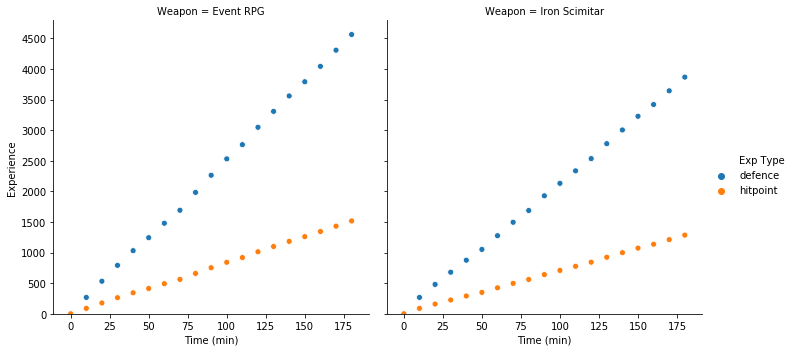

In [12]:
exp_scatter = sns.relplot(x = "Time (min)", 
                          y = "Exp Gained",
                          hue = "Exp Type", 
                          col = "Weapon",
                          data = combined_df)

exp_scatter.set(xlabel = "Time (min)",
                ylabel = "Experience",
                yticks = range(0, 5000, 500))

plt.ylim(0, None)
plt.show()

In [11]:
# extrapolate and obtain the amount of time required to reach level 75 defence (1210421 exp) from 133685 exp
rpg_time_required = calculate_time_required(133685, 1210421, rpg_results[0])
display_time_required("Event RPG", rpg_time_required)

scim_time_required = calculate_time_required(133685, 1210421, scim_results[0])
display_time_required("Iron Scimitar", scim_time_required)

709.0 hours are needed to reach level 75 Defence using the Event RPG
844.0 hours are needed to reach level 75 Defence using the Iron Scimitar
